### Train autoencoder network
- This notebook trains a convolutional autoencoder on the hdf5 dataset created by the syllable segmentation notebooks. 
- The trained model is then used to perform dimensionality reduction and generate novel stimuli

#### Import packages

In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline  
import os
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import hdbscan 
from sklearn import metrics

In [2]:
from avgn.network_analysis.network_analysis import *
import avgn.network.convnet_model as conv
from avgn.network.training import *

#### Allocate GPUs

In [3]:
gpus = [1] # Here I set CUDA to only see one GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpus])
num_gpus = len(gpus) # number of GPUs to use
if len(gpus) < 1:
    num_gpus = 1 

In [4]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print( [x.name for x in local_device_protos if x.device_type == 'GPU'] )

['/device:GPU:0']


#### Define data parameters

In [5]:
dims = [128, 128, 1] # first dimension of input data
batch_size = 16 # size of batches to use (per GPU)

### Load the dataset

In [6]:
from glob import glob

### Load the dataset

In [7]:
from glob import glob

In [8]:
bird_name = 'CAVI' 

In [9]:
hdf_locs = glob('../../../data/CAVI_wavs/*_'+str(dims[0])+'.hdf5')
hdf_locs[:4]

['../../../data/CAVI_wavs/YBuA_128.hdf5',
 '../../../data/CAVI_wavs/GRA_128.hdf5',
 '../../../data/CAVI_wavs/YAW_128.hdf5',
 '../../../data/CAVI_wavs/AGBk_128.hdf5']

In [10]:
def load_from_hdf5(hdf_locs, to_load):
    """Loads content from a list of HDF5 files"""
    hdf5_content = {}
    with h5py.File(hdf_locs[0],'r') as hf:
        for tl in to_load:
            hdf5_content[tl] = hf[tl].value
        hdf5_content['name'] = np.repeat(list(hf.attrs.values())[0], np.shape(hf['spectrograms'].value)[0])
        
    for i, folder in enumerate(hdf_locs[1:]):
        with h5py.File(folder,'r') as hf:
            if len(hf[to_load[0]].value) < 2500: continue
            print(folder, len(hf[to_load[0]].value))
            for tl in to_load:
                hdf5_content[tl] = np.append(hdf5_content[tl], hf[tl].value, axis = 0)
            hdf5_content['name'] = np.append(hdf5_content['name'], np.repeat(list(hf.attrs.values())[0], np.shape(hf['spectrograms'].value)[0]))
    return hdf5_content

In [11]:
# What information is stored in the HDF5 file
to_load = ['spectrograms', 'lengths', 'start', 'wav_file', 'syll_start_rel_wav', 'symbols']

In [12]:
all_content = load_from_hdf5(hdf_locs, to_load)
num_examples = len(all_content['name'])
num_examples

../../../data/CAVI_wavs/GRA_128.hdf5 3045
../../../data/CAVI_wavs/YAW_128.hdf5 3149
../../../data/CAVI_wavs/AGBk_128.hdf5 8185
../../../data/CAVI_wavs/AGO_128.hdf5 3869
../../../data/CAVI_wavs/WABk_128.hdf5 6430
../../../data/CAVI_wavs/BuRA_128.hdf5 5527
../../../data/CAVI_wavs/AOBu_128.hdf5 7638
../../../data/CAVI_wavs/ORA_128.hdf5 2805
../../../data/CAVI_wavs/RYA_128.hdf5 3565


46851

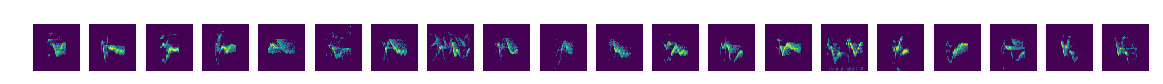

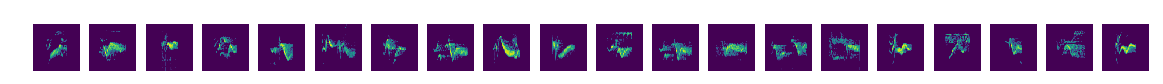

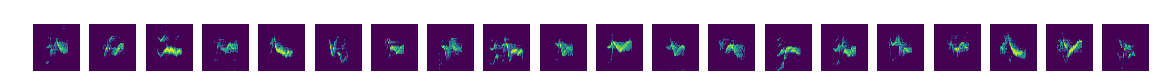

In [13]:
nex=20
for i in range(3):
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(nex,1))
    for i in range(nex):
        ax[i].matshow(all_content['spectrograms'][np.random.randint(len(all_content['spectrograms']))].reshape((dims[0],dims[1])),
                      cmap=plt.cm.viridis, interpolation='nearest', origin='lower')
        ax[i].axis('off')

#### Split dataset into training and validation sets 

In [14]:
val_pct = .1 # how much of the dataset to set aside for validation of reconstruction

In [15]:
validation_set = np.random.permutation(np.arange(len(all_content['spectrograms'])))[:int(len(all_content['spectrograms'])*val_pct)]
mask = np.ones(len(all_content['spectrograms']), np.bool)
mask[validation_set] = 0
validation_syllables = all_content['spectrograms'][validation_set]
training_syllables = all_content['spectrograms'][mask]
print(len(training_syllables), len(validation_syllables))

42166 4685


### Define the network
#### Network dimensions

In [16]:
# dimensions of network
# [depth, filter size, stride] # decoder will become inverse of encoder
encoder_dims = [
    [64, 3, 1],  # 64
    [64, 3, 2], # 64
    [128, 3, 1], # 64
    [64, 3, 2], # 32
    [128, 3, 1], # 32
    [64, 3, 2], # 16
    [128, 3, 1], # 16
    [2000, 0, 0], # 8
    [2000, 0, 0], # 8
]
decoder_dims = encoder_dims[::-1]
hidden_size = 2
latent_loss = 'distance' # Either 'None', 'distance', or 'VAE'

In [17]:
# Generate a unique key (e.g. datetime) for this training instance
network_identifier = 'Distance_AE_'+bird_name
now_string = datetime.now().strftime("%Y-%m-%d_%H-%M-%S") # this is used to identify this training instance
print(now_string)

2018-10-17_15-09-13


In [18]:
import pickle

In [19]:
# save params
param_loc = '../../../data/network_params/'+network_identifier+'/'
print(param_loc+now_string+'_params.pickle')
if not os.path.exists(param_loc):
                os.makedirs(param_loc) 
with open(param_loc+now_string+'_params.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([encoder_dims, decoder_dims, hdf_locs, dims, batch_size, hidden_size, validation_set, latent_loss], f)        

../../../../data/network_params/Distance_AE_CAVI/2018-10-17_15-09-13_params.pickle


In [20]:
model = conv.ConvAE(dims, batch_size, encoder_dims, decoder_dims, hidden_size, latent_loss=latent_loss, network_type='AE', gpus=[0], adam_eps = 1.0e-8, activation_fn=tf.nn.relu) # eps = 0.1 and lr = 1 (after lr 0.1)

Encoder shapes:  [(16, 128, 128, 1), (16, 128, 128, 64), (16, 64, 64, 64), (16, 64, 64, 128), (16, 32, 32, 64), (16, 32, 32, 128), (16, 16, 16, 64), (16, 32768), (16, 2000), (16, 2000)]
Decoder shapes:  [(16, 2), (16, 2000), (16, 2000), (16, 32, 32, 128), (16, 64, 64, 128), (16, 64, 64, 128), (16, 128, 128, 128), (16, 128, 128, 128), (16, 256, 256, 128), (16, 256, 256, 64), (16, 128, 128, 64), (16, 128, 128, 1), (16, 16384)]
Network Initialized


### Train the model

In [21]:
# define a training iterator over your data
iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)

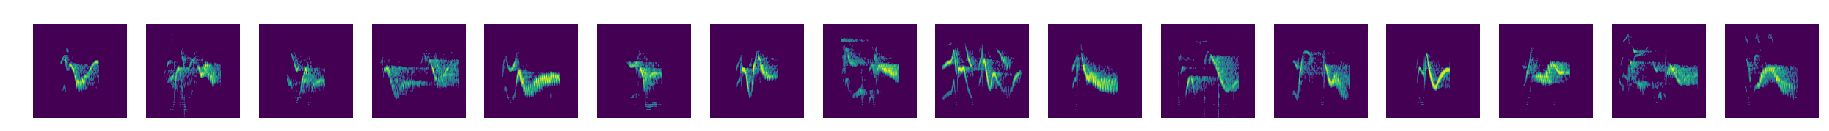

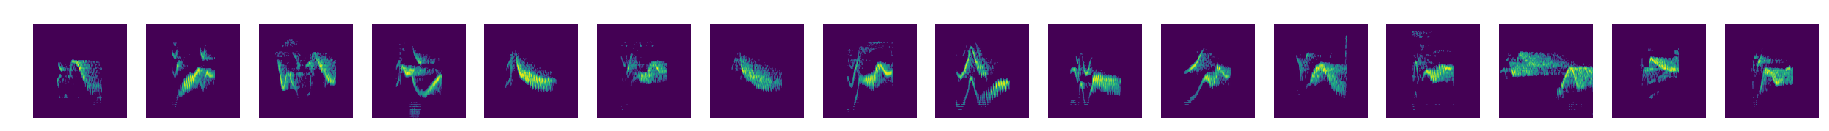

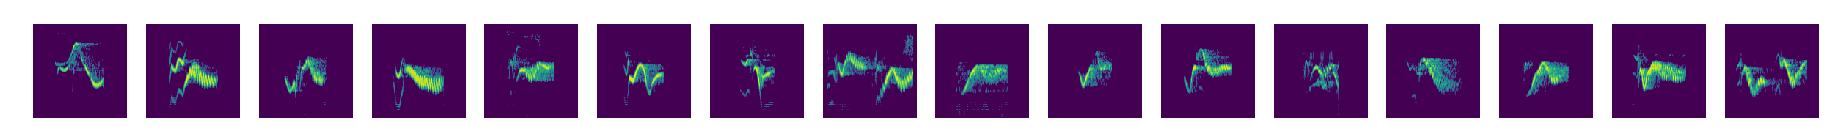

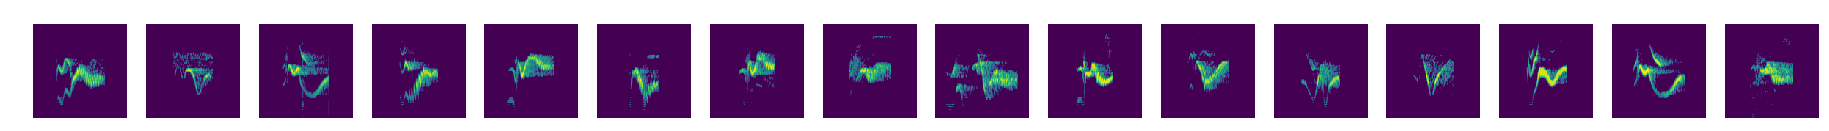

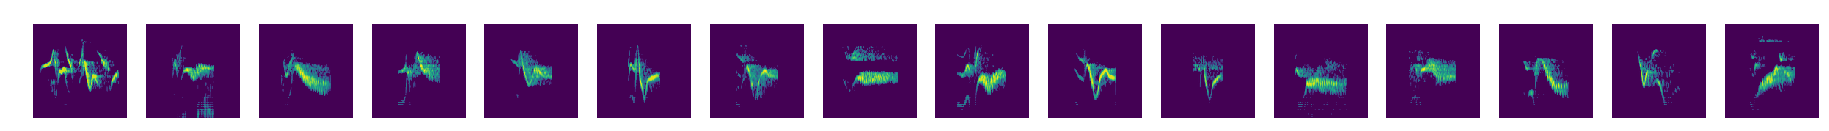

In [22]:
nex=16

for ii in range(5):
    example_data = iter_.__next__()[0]
    fig, ax = plt.subplots(nrows=1,ncols=nex, figsize=(nex*2,1*2))
    for i in range(nex):
        ax[i].matshow(example_data[i].reshape((dims[0],dims[1])), cmap=plt.cm.viridis, interpolation='nearest', origin='lower', vmin=0, vmax=1)
        ax[i].axis('off')
    plt.show()

#### train a single epoch to test

In [23]:
learning_rate = 1e-4
latent_loss_weights = 1e-1

In [24]:
# a list of which tensors to return from the network (e.g. train_D/G are necessary to train the network, losses are useful for plots)
return_list = ['train_D', 'train_E', 'L_d', 'L_e', 'recon_loss', 'distance_loss'] 
iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
validation_iter_ = data_iterator(validation_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)

#train_AE(model, iter_,dataset_size = len(training_syllables), validation_iter_=False, learning_rate = 1.0, return_list=return_list)
training_df, validation_df = train_AE(model, iter_,dataset_size = int(len(training_syllables)/100), validation_iter_=validation_iter_,validation_size=len(validation_syllables),
                                      learning_rate = learning_rate, return_list=return_list, latent_loss_weights=latent_loss_weights)

In [25]:
training_df[:3]

batch train_D train_E       L_d       L_e  recon_loss  distance_loss
0      1    None    None  0.231109  0.247681    0.231109       0.165724
1      2    None    None  0.229345  0.252315    0.229345       0.229699
2      3    None    None  0.231163  0.244521    0.231163       0.133577

#### Train the network in full

In [26]:
from datetime import datetime

In [27]:
### Parameters, etc...
num_epochs = 50 # how many epochs to train the network for
epoch = 0 # initialize epochs
save_loc = '../../../data/models/'+network_identifier + '/'+now_string+'/'
print(save_loc)
# Visualizations (these only work if you choose a 2D latent space - write a new viz function if you didn't...)
network_save_epochs = np.unique(np.logspace(0,np.log2(num_epochs),num=20, base= 2).astype('int')) # (epochs) - which epochs to save the network
network_save_epochs=network_save_epochs[network_save_epochs>50]
#network_visualize_progress = np.unique(np.logspace(0,np.log2(num_epochs),num=10000, base= 2).astype('int')) # how often to visualize the network (leave empty list for never)
network_visualize_progress = np.arange(num_epochs)
img_save_loc = '../../../img/'+network_identifier + '/'+now_string+'/'

../../../../data/models/Distance_AE_CAVI/2018-10-17_15-09-13/


In [28]:
#model.load_network('../../../../data/models/Distance_AE_CAVI/2018-10-17_10-00-27/28_model.tfmod')

33


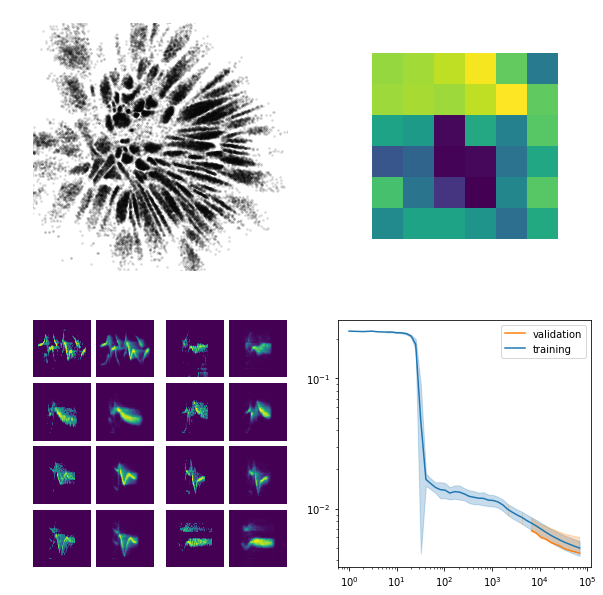

In [ ]:
try:
    for epoch in tqdm(range(epoch,num_epochs)):
        
        
        # visualization
        if epoch in network_visualize_progress:
            clear_output()
            print(epoch)
            visualize_2D_AE(model, training_df, validation_df, example_data, num_examples,
                            batch_size, num_gpus, dims, iter_, n_cols = 4, std_to_plot = 2.5,
                            save_loc = img_save_loc+now_string+'/'+str(epoch)+'.jpg')
        
        # training
        iter_ = data_iterator(training_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
        validation_iter_ = data_iterator(validation_syllables,y=None,batch_size=batch_size,num_gpus=num_gpus,dims=dims)
        training_df_epoch, validation_df_epoch = train_AE(model, iter_, dataset_size = len(training_syllables),
                                              validation_iter_=validation_iter_,validation_size=len(validation_syllables),
                                              learning_rate = learning_rate, return_list=return_list,
                                                         latent_loss_weights=latent_loss_weights)
        training_df = pd.concat([training_df, training_df_epoch])
        validation_df = pd.concat([validation_df, validation_df_epoch])
        
        # save network
        if epoch in network_visualize_progress:
            if not os.path.exists(save_loc):
                os.makedirs(save_loc) 
            model.save_network(save_loc+str(epoch)+'_model.tfmod')
        
except KeyboardInterrupt:
    print('interrupted by keyboard')

In [64]:
print(epoch)

49


In [65]:
### save this model
if not os.path.exists(save_loc+'manual/'):
    os.makedirs(save_loc+'manual/') 
model.save_network(save_loc+'manual/manual_model.tfmod')

Network Saved


### Translate syllables into latent space

In [246]:
def encode_x(x, z_shape,batch_size):
    nex =np.ceil(len(x)/batch_size).astype('int')
    face_z = np.zeros([nex*batch_size] + list(z_shape))
    face_x = np.zeros([nex*batch_size] + list(np.shape(x)[1:]))
    face_x[:len(x)] = x
    for batch in np.arange(nex):
        cur_batch = face_x[int(batch*batch_size):int((batch+1)*batch_size)]
        z_out = model.sess.run(model.z_x,{model.x_input: cur_batch})
        face_z[batch*batch_size:(batch+1)*batch_size,:] = z_out
    z_final = face_z[:len(x)]
    return z_final

def decode_z(z, x_shape, batch_size):
    nex =np.ceil(len(z)/batch_size).astype('int')
    face_x = np.zeros([nex*batch_size] + list(x_shape))
    face_z = np.zeros([nex*batch_size] + list(np.shape(z)[1:]))
    face_z[:len(z)] = z
    for batch in np.arange(nex):
        cur_batch = face_z[int(batch*batch_size):int((batch+1)*batch_size)]
        x_out = model.sess.run(model.x_tilde,{model.z_x: cur_batch})
        face_x[batch*batch_size:(batch+1)*batch_size,:] = x_out
    x_final = face_x[:len(z)]
    return x_final

In [240]:
x = all_content['spectrograms']/255.
z = encode_x(np.reshape(x, (len(x), np.prod(np.shape(x)[1:]))), [2], model.batch_size)
print(np.shape(z))

KeyboardInterrupt: 

In [108]:
BirdData = pd.DataFrame({
        'specs':all_content['spectrograms'].tolist(), 
        'z':z.tolist(),
        'syllable_time': [datetime.strptime(i, '%d/%m/%y %H:%M:%S.%f') for i in all_content['start'].astype('str').tolist()] , 
        'syll_length_s': all_content['lengths'].tolist(), 
        'start_time_rel_wav': all_content['syll_start_rel_wav'].tolist(), 
        'original_wav': all_content['wav_file'].tolist(), 
    })
BirdData[:3]

original_wav  \
0  b'../../../data/bird-db/CAVI/YBuA/wavs/2014-05...   
1  b'../../../data/bird-db/CAVI/YBuA/wavs/2014-05...   
2  b'../../../data/bird-db/CAVI/YBuA/wavs/2014-05...   

                                               specs  start_time_rel_wav  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...             48728.0   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            101560.0   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            156560.0   

   syll_length_s              syllable_time  \
0       0.270068 2014-05-26 08:46:01.104943   
1       0.332381 2014-05-26 08:46:02.302948   
2       0.360091 2014-05-26 08:46:03.550113   

                                            z  
0      [4.037062168121338, 3.048987865447998]  
1      [5.983214378356934, 5.963729381561279]  
2  [-3.3138232231140137, -0.7195714712142944]

### Cluster latent representations

In [109]:
# we set the minimum cluster size at 0.25% of the dataset ()
cluster_pct = 0.0025

In [110]:
min_cluster_size = int(len(z)*cluster_pct)
min_cluster_size

117

In [111]:
np.shape(np.array(list(BirdData.z.values)))

(46851, 2)

In [112]:
BirdData['labels'] = cluster_data(np.array(list(BirdData.z.values)),
                          hdbscan.HDBSCAN,
                          (),
                          {'min_cluster_size':min_cluster_size,  'min_samples':1},
                         verbose = True)

Clustering took 64.70 s


In [113]:
# check how many syllables were labelled
pct_unlabelled = np.sum(BirdData['labels'] == -1)/len(BirdData['labels'])
print(str(round(pct_unlabelled*100,1))+ '% of syllables went unlabelled')

8.4% of syllables went unlabelled


In [196]:
def plot_with_labels(data, labels, title = '', ax = None, figsize = (9,9)):
    palette = sns.color_palette('husl', len(np.unique(labels)))
    labs_to_numbers_dict = {l:i for i,l in enumerate(np.unique(labels))}
    np.random.shuffle(palette)
    colors = [palette[labs_to_numbers_dict[x]] if x >= 0 else (0.75, 0.75, 0.75) for x in np.array(labels)]

    if not ax: fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(data.T[0], data.T[1],
               color=colors, alpha = 1, linewidth= 0, s=10)
    ax.axis('off')
    ax.set_title(title)
    if not ax: plt.show()
        
def compareLabellingSchemes(lab1, lab2, x, figsize=(24,24)):
    # get palette for first labelling
    palette = sns.color_palette('husl', len(np.unique(lab1)))
    labs_to_numbers_dict = {l:i for i,l in enumerate(np.unique(lab1))}
    np.random.shuffle(palette)
    colors = [palette[labs_to_numbers_dict[x]] if int(x) >= 0 else (0.75, 0.75, 0.75) for x in np.array(lab1)]
    
    # plot first labelling
    fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(z.T[0], z.T[1],
               color=colors, alpha = 1, linewidth= 0, s=10)
    ax.axis('off')
    plt.show()
    
    # compare labels
    used_labs = []
    unchanged_labs = []
    for lab in np.unique(lab2):
        lab1_labs = lab1[lab2 == lab]
        closest_lab = np.unique(lab1_labs)[np.argmax([list(lab1_labs).count(i) for i in np.unique(lab1_labs)])]
        if closest_lab not in used_labs:
            used_labs.append(closest_lab)
            lab2[lab2 == lab] = closest_lab
        else: 
            unchanged_labs.append(lab)
    
    # get palette for second labelling
    palette = palette + sns.hls_palette(len(np.unique(unchanged_labs)), l=.5, s=.8)
    ul = len(np.unique(lab1))
    for ilab, lab in enumerate(unchanged_labs):
        labs_to_numbers_dict[lab] = ilab + ul
    colors = [palette[labs_to_numbers_dict[x]] for x in np.array(lab2)]
    
    fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(z.T[0], z.T[1],
               color=colors, alpha = 1, linewidth= 0, s=10)
    ax.axis('off')
    plt.show()

### Compute labelling metrics

In [186]:
lab1 = np.array(BirdData['labels'].values).astype('str')
lab2 = np.array(all_content['symbols']).astype('str')

In [194]:
def compareLabellingSchemes(lab1, lab2, z, figsize=(24,24)):
    # get palette for first labelling
    palette = sns.color_palette('husl', len(np.unique(lab1)))
    labs_to_numbers_dict = {l:i for i,l in enumerate(np.unique(lab1))}
    np.random.shuffle(palette)
    colors = [palette[labs_to_numbers_dict[x]] if int(x) >= 0 else (0.75, 0.75, 0.75) for x in np.array(lab1)]
    
    # plot first labelling
    fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(z.T[0], z.T[1],
               color=colors, alpha = 1, linewidth= 0, s=10)
    ax.axis('off')
    plt.show()
    
    # compare labels
    used_labs = []
    unchanged_labs = []
    for lab in np.unique(lab2):
        lab1_labs = lab1[lab2 == lab]
        closest_lab = np.unique(lab1_labs)[np.argmax([list(lab1_labs).count(i) for i in np.unique(lab1_labs)])]
        if closest_lab not in used_labs:
            used_labs.append(closest_lab)
            lab2[lab2 == lab] = closest_lab
        else: 
            unchanged_labs.append(lab)
    
    # get palette for second labelling
    palette = palette + sns.hls_palette(len(np.unique(unchanged_labs)), l=.5, s=.8)
    ul = len(np.unique(lab1))
    for ilab, lab in enumerate(unchanged_labs):
        labs_to_numbers_dict[lab] = ilab + ul
    colors = [palette[labs_to_numbers_dict[x]] for x in np.array(lab2)]
    
    fig, ax= plt.subplots(nrows=1,ncols=1,figsize=figsize)
    ax.scatter(z.T[0], z.T[1],
               color=colors, alpha = 1, linewidth= 0, s=10)
    ax.axis('off')
    plt.show()

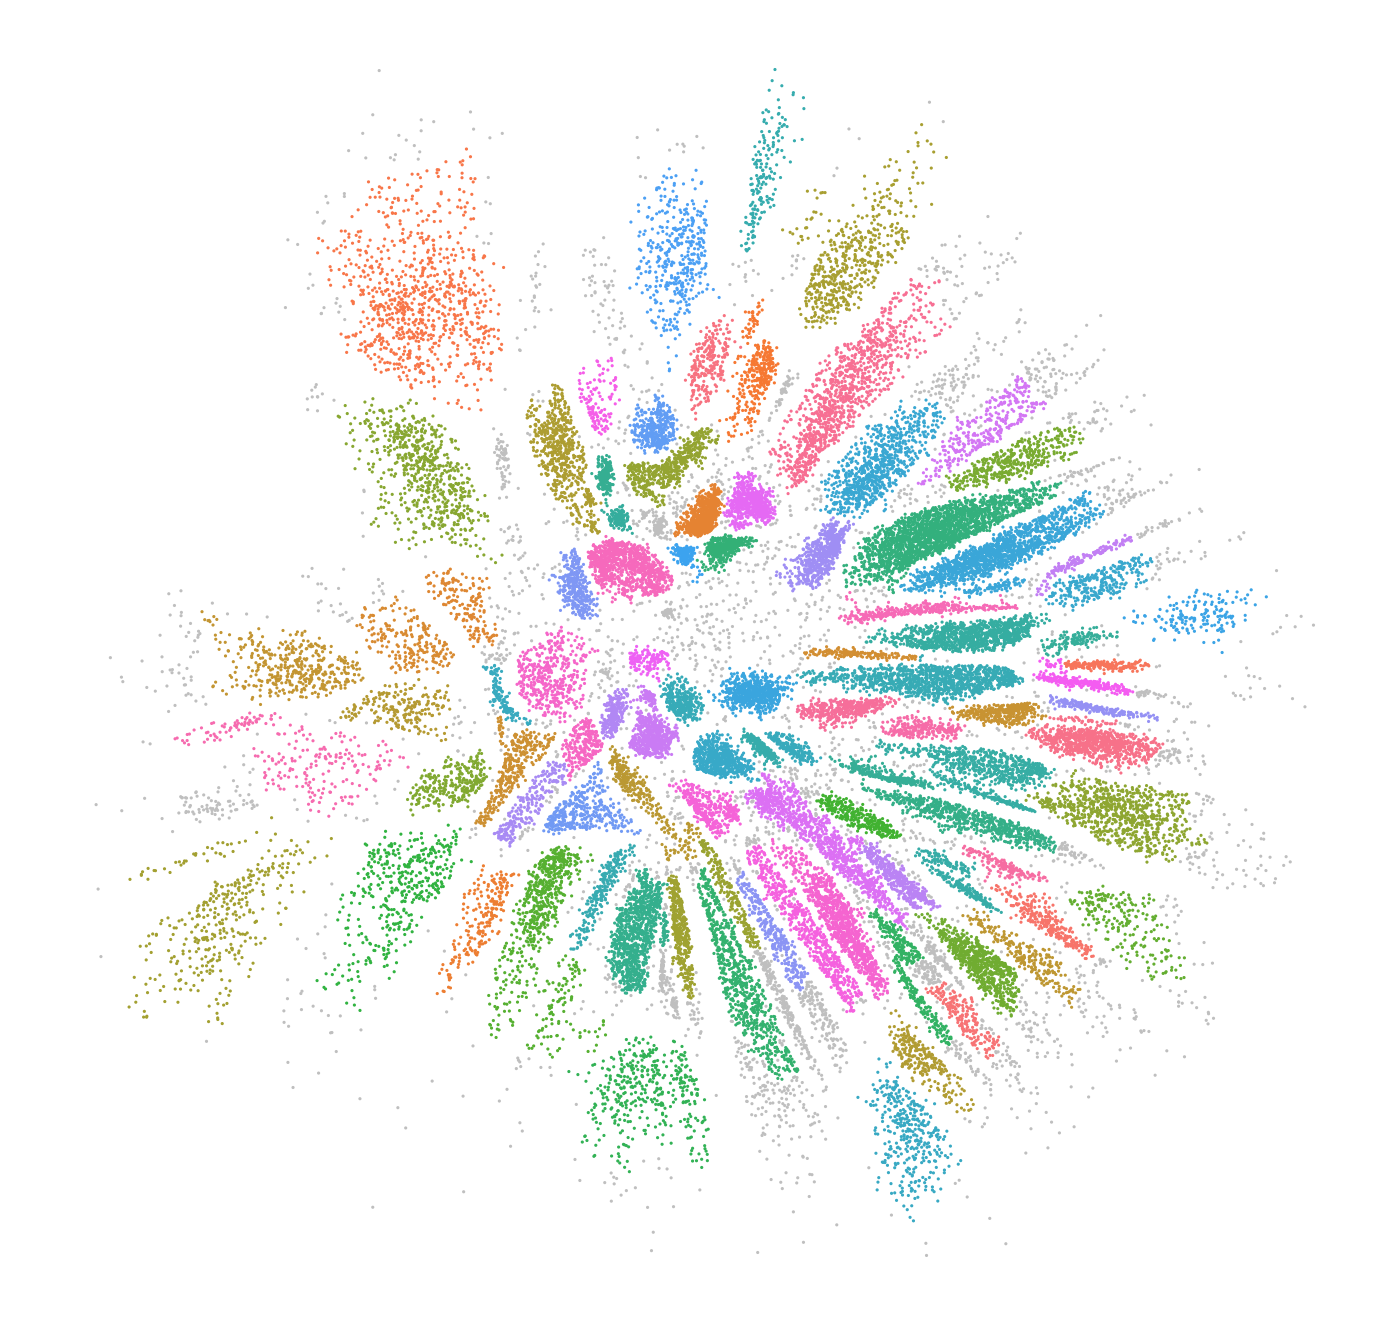

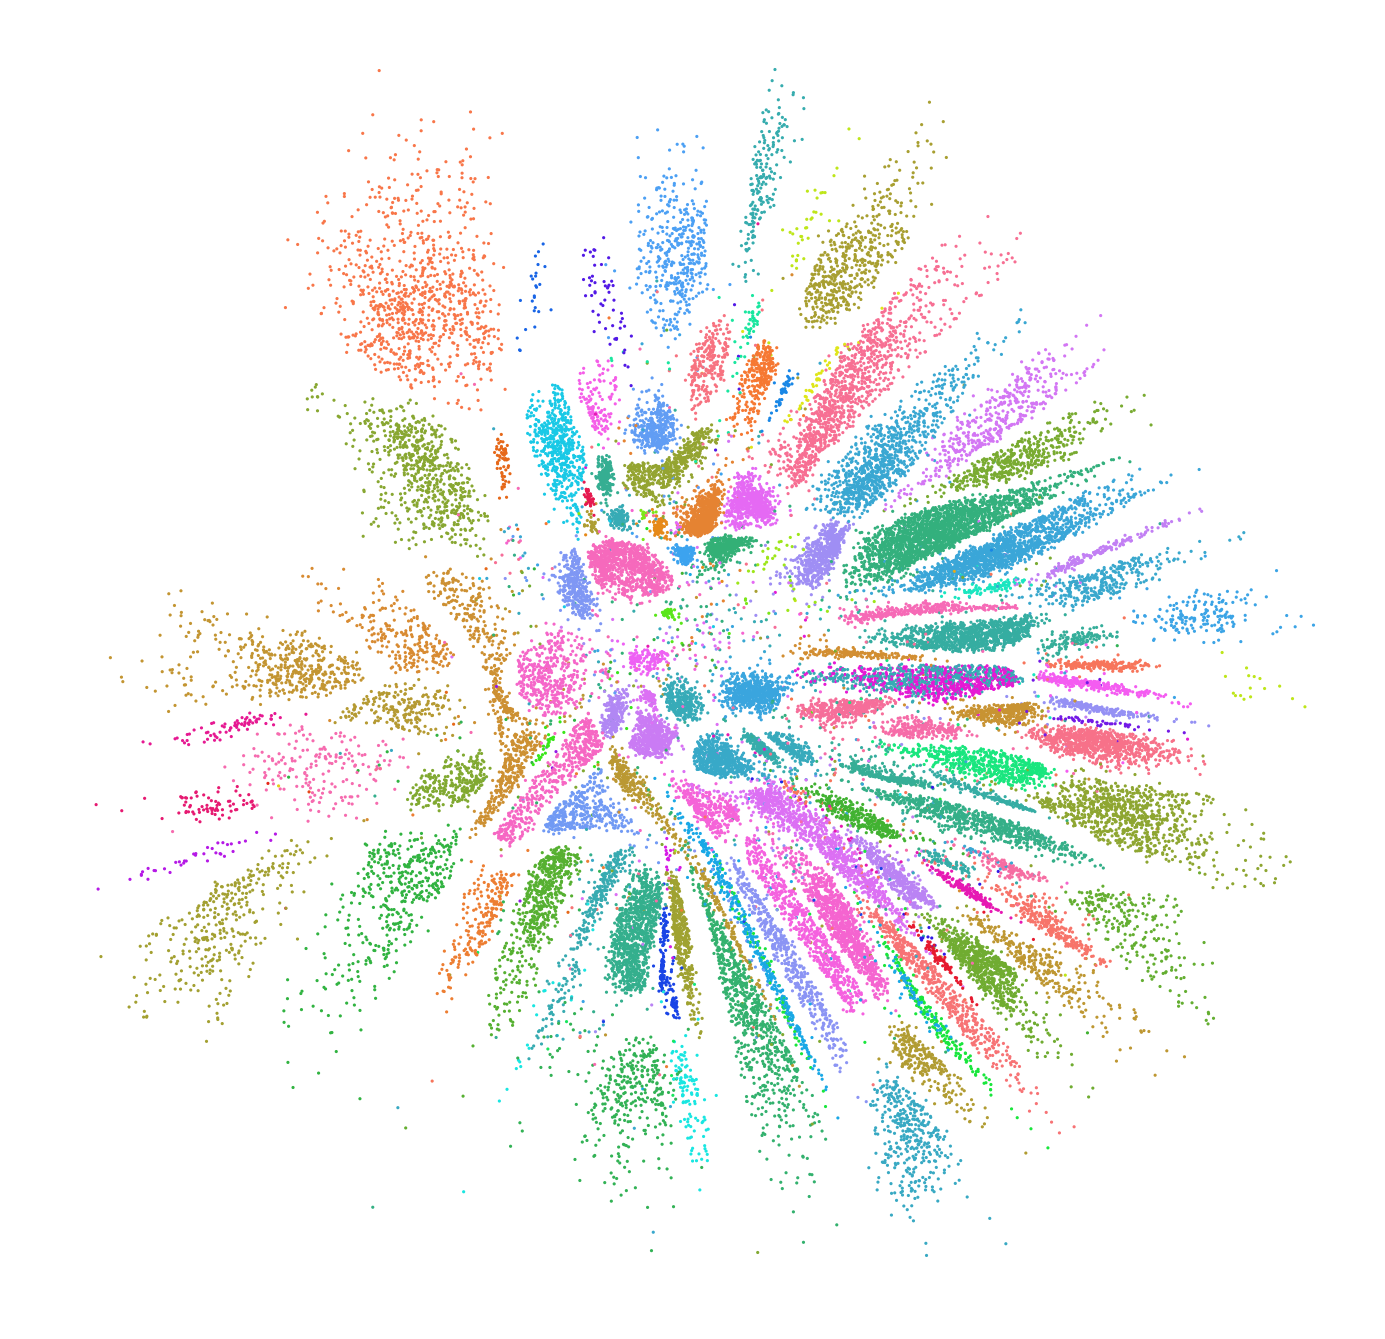

In [195]:
compareLabellingSchemes(lab1, lab2, x)

In [199]:
# score everything
print(
    metrics.fowlkes_mallows_score(lab1,lab2),
    metrics.homogeneity_score(lab1,lab2),
    metrics.completeness_score(lab1,lab2),
    metrics.v_measure_score(lab1,lab2),
    metrics.adjusted_mutual_info_score(lab1,lab2),
    metrics.normalized_mutual_info_score(lab1,lab2),
    metrics.adjusted_rand_score(lab1,lab2)
)

0.7086997195042992 0.9057544820934845 0.8671260882963892 0.8860194579738975 0.8634024683080184 0.8862298466056339 0.6937895935370731


In [201]:
#score only clustered
mask = lab1 != '-1'
print(
    metrics.fowlkes_mallows_score(lab1[mask],lab2[mask]),
    metrics.homogeneity_score(lab1[mask],lab2[mask]),
    metrics.completeness_score(lab1[mask],lab2[mask]),
    metrics.v_measure_score(lab1[mask],lab2[mask]),
    metrics.adjusted_mutual_info_score(lab1[mask],lab2[mask]),
    metrics.normalized_mutual_info_score(lab1[mask],lab2[mask]),
    metrics.adjusted_rand_score(lab1[mask],lab2[mask])
)

0.9135550320034324 0.955144224454688 0.9412229324412628 0.9481324801227861 0.9395410545036074 0.9481580289411555 0.9118296541985396


### Generate grid of vocalizations

In [203]:
np.min(z[:,0]), np.max(z[:,0]), np.min(z[:,1]), np.max(z[:,1])

(-13.105486869812012, 15.90878677368164, -13.3663330078125, 14.18693733215332)

(1280, 1280)


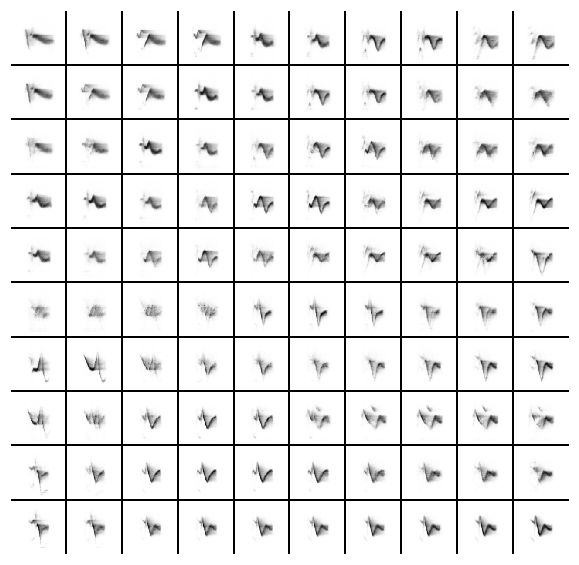

In [220]:
spacing = .5
xs = [3, 8]
ys = [-5, 0]
xv,yv = draw_grid(model,dims,batch_size,xs,ys,spacing = spacing, zoom = 1)

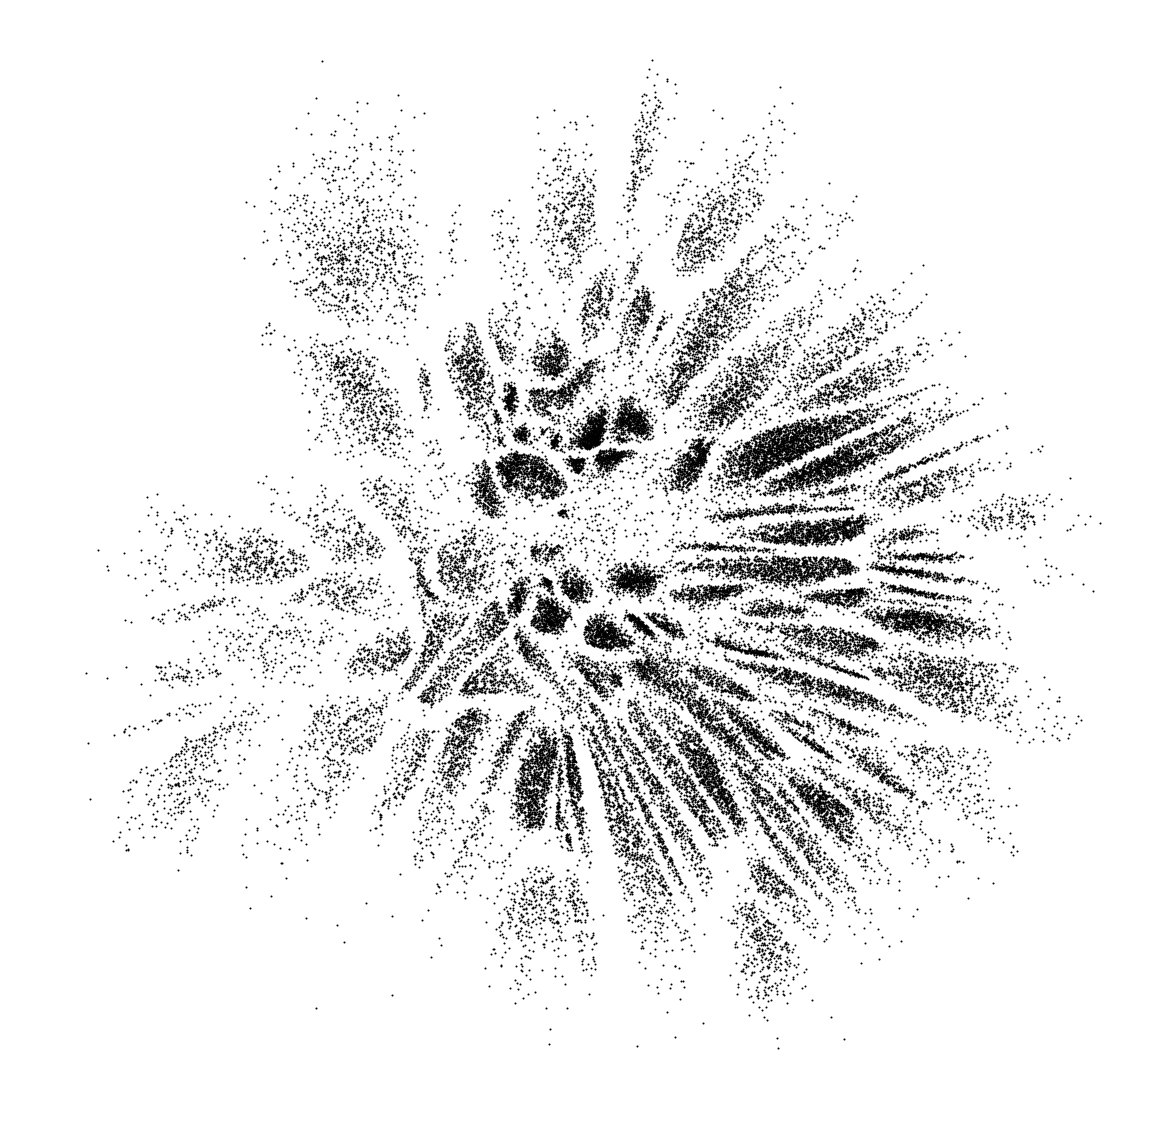

In [223]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,20))
ax.scatter(z[:,0], z[:,1], color='k', s=1)
#ax.scatter(xv, yv, color='r', s=30)
ax.axis('off')
plt.show()

### Interpolate between syllables

In [224]:
### choose two points
# get their z values
# interpolate between those z values
# pass those z values into network (encode them)
# plot a figure of this interpolation, save a gif

(-0.5, 127.5, -0.5, 127.5)

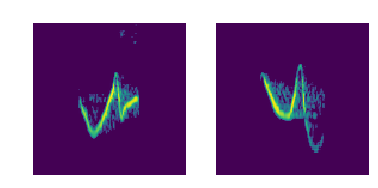

In [325]:
pt1 = 0; pt2 = 300
syllable_1 = all_content['spectrograms'][pt1]
syllable_2= all_content['spectrograms'][pt2]
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(6,3))
ax[0].matshow(syllable_1, origin = 'lower'); ax[0].axis('off')
ax[1].matshow(syllable_2, origin = 'lower'); ax[1].axis('off')

In [326]:
n_frames_per_interp = 16 # how many points in interp.
z1 = encode_x(np.array([syllable_1.flatten()/255.]), [2], batch_size)[0]
z2 = encode_x(np.array([syllable_2.flatten()/255.]), [2], batch_size)[0]
pcts = np.linspace(0,1,n_frames_per_interp+1)[:-1]
interp_z = np.array([(z1*pct) + (z2*(1.-pct)) for pct in tqdm(pcts, leave=False)])
x_interp = decode_z(interp_z, [np.prod(dims[:-1])], batch_size)

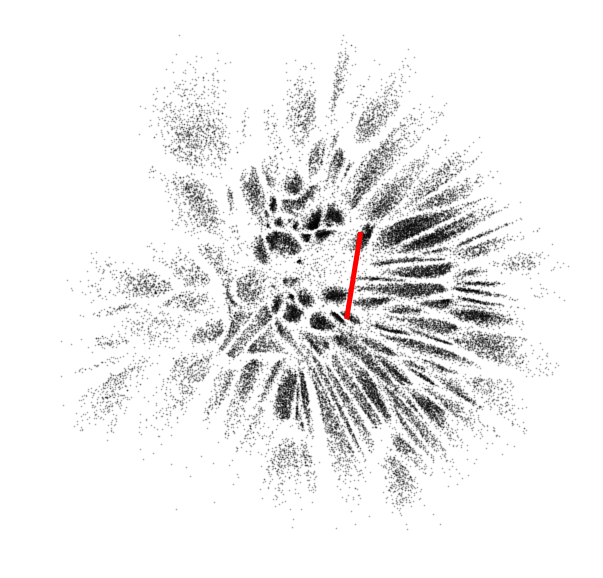

In [327]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,10))
ax.plot([z1[0],z2[0]], [z1[1],z2[1]], color='red', lw=5)
ax.scatter(z[:,0], z[:,1], color='k', s=1, alpha=.2)

#ax.scatter(xv, yv, color='r', s=30)
ax.axis('off')
plt.show()

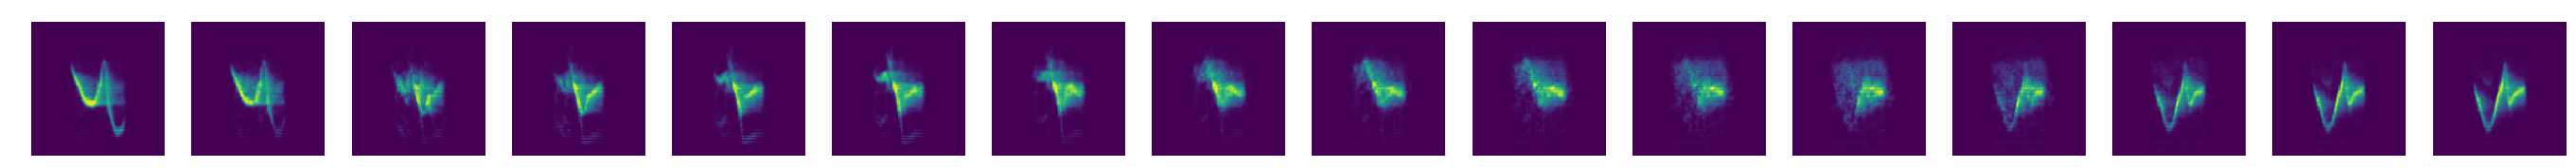

In [328]:
fig, ax = plt.subplots(nrows=1,ncols=n_frames_per_interp, figsize=(n_frames_per_interp*3,3))
for frame in range(n_frames_per_interp):
    ax[frame].matshow(np.squeeze(x_interp[frame].reshape(dims)), origin = 'lower')
    ax[frame].axis('off')

### Demo recovering audio from a generated syllable

In [329]:
import pickle
import avgn.spectrogramming.spectrogramming as sg
import skimage.transform
import IPython.display
from PIL import Image

In [330]:
# load dictionary with spectrogram parameters
dict_now_string = '2018-10-17_13-40-37'
dict_loc = '../../../data/parameter_dictionaries/'+dict_now_string+'_dict.pickle'
with open(dict_loc, 'rb') as f:
    hparams = pickle.load(f)
globals().update(hparams)

In [331]:
_mel_basis = sg._build_mel_basis(hparams) # build a basis function if you are using a mel spectrogram
mel_inversion_filter = (_mel_basis.T / _mel_basis.sum(axis=1))
mel_inversion_filter =np.nan_to_num(np.transpose(mel_inversion_filter / mel_inversion_filter.sum(axis=1)[:, np.newaxis]))

/mnt/cube/tsainbur/conda_envs/txori_py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [332]:
def rescale(X, out_min, out_max):
    return out_min + (X - np.min(X)) * ((out_max - out_min) / (np.max(X) - np.min(X)))

In [333]:
def invertSyllableToWav(syll, dims, hparams):
    syll = np.squeeze(syll.reshape(dims))
    # reshape spectrogram 
    if hparams['mel_filter']:
        resize_shape = (int((np.shape(syll)[1]/hparams['resize_samp_fr']) * (1000/hparams['frame_shift_ms'])), hparams['num_freq_final'])
        syll = np.array(Image.fromarray(np.squeeze(syll)).resize(resize_shape, Image.ANTIALIAS))
        syll = np.dot(syll.T, mel_inversion_filter).T
    else:
        resize_shape = (int((np.shape(syll)[1]/hparams['resize_samp_fr']) * (1000/hparams['frame_shift_ms'])), hparams['num_freq'])
        syll = np.array(Image.fromarray(np.squeeze(syll)).resize(resize_shape, Image.ANTIALIAS))
    ### adding some noise tends to improve reconstruction quality
    syll = rescale(syll, .25,1) +np.reshape(np.random.rand(np.prod(np.shape(syll)))*.25, np.shape(syll))
    # invert spectrogram
    waveform = sg.inv_spectrogram(rescale(syll, .25,1), hparams)
    return waveform


In [337]:
len(invert_wavs[0])

29216

In [334]:
invert_wavs = [invertSyllableToWav(i, dims, hparams) for i in tqdm(x_interp)]

In [336]:
# play back a sample of the song
IPython.display.Audio(data=np.concatenate(invert_wavs), rate=hparams['sample_rate'])

### Make a sequence dataframe

In [83]:
# maximum amount of time allowed to pass before considering this bout new
max_timedelta = 10. # seconds
# minimum amount of syllables/units allowed to be considered part of a sequence
seq_len_cutoff = 2 # syllables/units

In [84]:
# Add sequence information to bird dataframe
BirdData = split_times_into_seqs(BirdData, max_timedelta, seq_len_cutoff)

In [85]:
BirdData[:3]

original_wav  \
0  b'../../../data/bird-db/CAVI/YBuA/wavs/2014-05...   
1  b'../../../data/bird-db/CAVI/YBuA/wavs/2014-05...   
2  b'../../../data/bird-db/CAVI/YBuA/wavs/2014-05...   

                                               specs  start_time_rel_wav  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...             48728.0   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            101560.0   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...            156560.0   

   syll_length_s              syllable_time  \
0       0.270068 2014-05-26 08:46:01.104943   
1       0.332381 2014-05-26 08:46:02.302948   
2       0.360091 2014-05-26 08:46:03.550113   

                                            z  labels  day_num  \
0      [4.037062168121338, 3.048987865447998]      55     29.0   
1      [5.983214378356934, 5.963729381561279]      56     29.0   
2  [-3.3138232231140137, -0.7195714712142944]      42     29.0   

   sequence_syllable  sequence_num  
0                0.0        1375.0  
1                1.0        1375.0  
2                2.0        1375.0

In [86]:
sequence_df = syllables_to_sequences( BirdData, ['labels','z','original_wav', 'specs','start_time_rel_wav','syll_length_s']).rename(columns={'labels': 'sequence'})
sequence_df['lens'] = [len(i) for i in sequence_df.sequence.values]

In [87]:
print(len(sequence_df))
sequence_df[:3]

1850


sequence_num                                      sequence_type  \
0           0.0  [labels, z, original_wav, specs, start_time_re...   
1           1.0  [labels, z, original_wav, specs, start_time_re...   
2           2.0  [labels, z, original_wav, specs, start_time_re...   

                                            sequence  \
0  [92, 78, 71, 23, 23, 23, 23, 23, 10, 48, 61, 5...   
1                                       [10, 10, 10]   
2                               [23, 61, -1, 48, 52]   

                                                   z  \
0  [[5.298986434936523, -4.530872821807861], [10....   
1  [[-5.573022365570068, -5.846517562866211], [-5...   
2  [[1.0872575044631958, -6.673682689666748], [9....   

                                        original_wav  \
0  [b'../../../data/bird-db/CAVI/AGBk/wavs/2013-0...   
1  [b'../../../data/bird-db/CAVI/AGBk/wavs/2013-0...   
2  [b'../../../data/bird-db/CAVI/AGBk/wavs/2013-0...   

                                               specs  \
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                                  start_time_rel_wav  \
0  [3028586.0, 3231242.0, 3511955.0, 3776483.0, 3...   
1                  [5728495.0, 5993022.0, 6364160.0]   
2  [7144734.0, 7420102.0, 7518009.0, 7635614.0, 7...   

                                       syll_length_s  lens  
0  [0.29775509238243103, 0.3081405758857727, 0.29...    14  
1  [0.5643764138221741, 0.5886167883872986, 0.571...     3  
2  [0.335850328207016, 0.3081405758857727, 0.5886...     5

In [88]:
### Save the sequence dataframe
sequence_df_loc = '../../../data/sequence_df/'+network_identifier+'/'+now_string+'/'
sequence_df_name = now_string+'_params.pickle'
if not os.path.exists(sequence_df_loc):
    os.makedirs(sequence_df_loc) 
sequence_df.to_pickle(sequence_df_loc+sequence_df_name)

### Visualize sequences

In [89]:
len(sequence_df['z'].values)

1850

In [90]:
sequence_df[:5]

sequence_num                                      sequence_type  \
0           0.0  [labels, z, original_wav, specs, start_time_re...   
1           1.0  [labels, z, original_wav, specs, start_time_re...   
2           2.0  [labels, z, original_wav, specs, start_time_re...   
3           3.0  [labels, z, original_wav, specs, start_time_re...   
4           4.0  [labels, z, original_wav, specs, start_time_re...   

                                            sequence  \
0  [92, 78, 71, 23, 23, 23, 23, 23, 10, 48, 61, 5...   
1                                       [10, 10, 10]   
2                               [23, 61, -1, 48, 52]   
3                               [92, 78, 71, 82, 71]   
4  [71, 79, 71, 79, 9, 72, 92, 23, -1, 5, 80, 7, ...   

                                                   z  \
0  [[5.298986434936523, -4.530872821807861], [10....   
1  [[-5.573022365570068, -5.846517562866211], [-5...   
2  [[1.0872575044631958, -6.673682689666748], [9....   
3  [[5.931704044342041, -5.599955081939697], [9.7...   
4  [[7.53463888168335, 3.5966897010803223], [8.99...   

                                        original_wav  \
0  [b'../../../data/bird-db/CAVI/AGBk/wavs/2013-0...   
1  [b'../../../data/bird-db/CAVI/AGBk/wavs/2013-0...   
2  [b'../../../data/bird-db/CAVI/AGBk/wavs/2013-0...   
3  [b'../../../data/bird-db/CAVI/AGBk/wavs/2013-0...   
4  [b'../../../data/bird-db/CAVI/AGBk/wavs/2013-0...   

                                               specs  \
0  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
1  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
2  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
3  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   
4  [[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...   

                                  start_time_rel_wav  \
0  [3028586.0, 3231242.0, 3511955.0, 3776483.0, 3...   
1                  [5728495.0, 5993022.0, 6364160.0]   
2  [7144734.0, 7420102.0, 7518009.0, 7635614.0, 7...   
3  [9228093.0, 9384330.0, 9500713.0, 9601674.0, 9...   
4  [10284951.0, 10376140.0, 10659602.0, 10761326....   

                                       syll_length_s  lens  
0  [0.29775509238243103, 0.3081405758857727, 0.29...    14  
1  [0.5643764138221741, 0.5886167883872986, 0.571...     3  
2  [0.335850328207016, 0.3081405758857727, 0.5886...     5  
3  [0.33931973576545715, 0.3081405758857727, 0.30...     5  
4  [0.29775509238243103, 0.2943083941936493, 0.29...    32

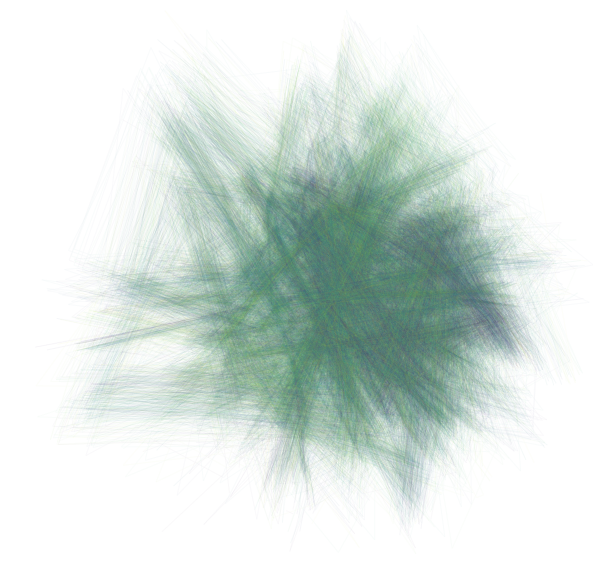

In [91]:
draw_transition_diagram(sequence_df['z'].values, num_ex=len(sequence_df), alpha=.025, linewidth=1, cmap=plt.cm.viridis)

### Plot a histogram of sequence lengths

Text(0,0.5,'Count')

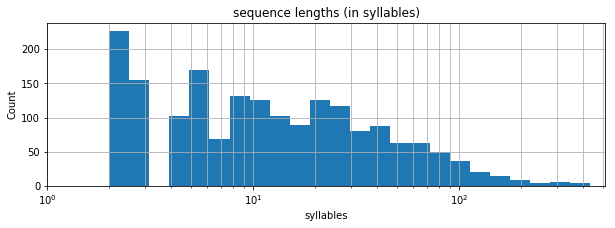

In [92]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10, 3))
nbins= 50
bins = np.logspace(np.log10(np.min(sequence_df['lens'].values)),  np.log10(np.max(sequence_df['lens'].values)),25)
ax.hist(sequence_df['lens'].values, bins =bins)
ax.set_xscale( "log" , basex=10)
ax.grid(True,which="both",ls="-")
ax.set_xlim((1, 512))
ax.set_title('sequence lengths (in syllables)')
ax.set_xlabel('syllables')
ax.set_ylabel('Count')

### Calculate the intersyllabic interval for this bird

In [93]:
from datetime import timedelta
et = [(i+timedelta(seconds = j)) for i,j in zip(np.array(BirdData.syllable_time.values).astype('M8[ms]').astype('O'), BirdData.syll_length_s.values)]
BirdData = BirdData.assign(end_time = list(et)).sort_values(by='syllable_time')
BirdData.index = np.arange(len(BirdData))
isi = [row.syllable_time - BirdData.loc[index-1].end_time for index, row in tqdm(BirdData.iterrows(), leave=False) if index != 0]
isi_secs = np.array([i.total_seconds() for i in isi])

Text(0,0.5,'Count')

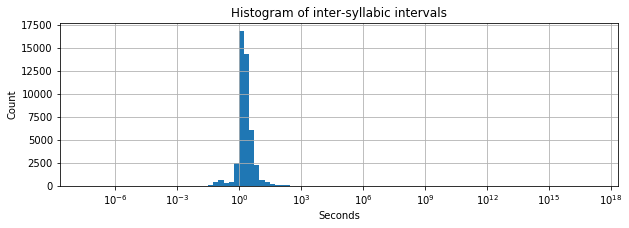

In [94]:
fig,ax = plt.subplots(ncols=1,nrows=1, figsize=(10,3))
ax.set_title('Histogram of inter-syllabic intervals')
bins = np.logspace(np.log(np.min(isi_secs[isi_secs > 0])), np.log(np.max(isi_secs)), 100)
hist= ax.hist(isi_secs,bins=bins)
ax.set_xscale("log", basex=10,nonposx='clip')
ax.grid(True,which="both",ls="-")
ax.set_xlabel('Seconds')
ax.set_ylabel('Count')

### Generate novel syllables